# Setup

In [1]:
DATA_VERSION = "2025-07-29"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
DOCUMENT_EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)
CONSULTATION_EMBEDDINGS_FILE_NAME = (
    f"consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    # "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40

_approximate_topic_f1_scores = {
    "administration": 0.534,
    "agriculture": 0.834,
    "communications": 0.66,
    "culture": 0.594,
    "defense": 0.633,
    "economics": 0.555,
    "education": 0.8,
    "energy": 0.907,
    "environment": 0.762,
    "finance": 0.651,
    "foreign_policy": 0.625,
    "health": 0.835,
    "housing": 0.723,
    "insurance": 0.859,
    "it": 0.632,
    "law": 0.639,
    "migration": 0.873,
    "political_system": 0.828,
    "public_finance": 0.722,
    "science": 0.588,
    "security": 0.554,
    "social": 0.554,
    "spatial_planning": 0.732,
    "sports": 0.82,
    "transportation": 0.833,
}

# TOPIC_SELECTION_F1_FILTER = None
TOPIC_SELECTION_F1_FILTER = 0.8

IGNORE_TOPICS = (
    set()
    if TOPIC_SELECTION_F1_FILTER is None
    else {t for t, f1 in _approximate_topic_f1_scores.items() if f1 < TOPIC_SELECTION_F1_FILTER}
)

DOC_TYPES = {
    "DRAFT",
    # None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    "REPORT",
    "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2712

In [2]:
%load_ext autoreload
%autoreload 2

import functools
import pathlib
import sys
from typing import Any

import dotenv
import iterstrat.ml_stratifiers
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.pipeline import Pipeline
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.consultation_topics.model
import demokratis_ml.models.consultation_topics.preprocessing
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_consultation_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_embeddings_file", DOCUMENT_EMBEDDINGS_FILE_NAME)
mlflow.log_param("consultation_embeddings_file", CONSULTATION_EMBEDDINGS_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("topic_selection_f1_filter", TOPIC_SELECTION_F1_FILTER)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = adorable-sponge-142


''

In [5]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/31 13:52:39 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [6]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)
DOCUMENT_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DOCUMENT_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(DOCUMENT_EMBEDDINGS_DATA_FILE)
CONSULTATION_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / CONSULTATION_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(CONSULTATION_EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-29.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-29.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-2025-07-29.parquet already exists locally.


In [7]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
6,1CAJoURQMxKeqCdQ564eYH,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfjrEEFeu6PDxuCd16,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,1CAJoURQbi5gxw7Wp5N5rT,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfmiLy7uCJJK4xiJ4o,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,1CAJoURQbi5gxw7WpL8ns1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfoMZEhmu1hg9dvJGj,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
18,1CAJoURQbi5gxw7Wpjj86f,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wg4pF6iCrNJakW9ic5,fedlex,manual,fedlex,Juni 2022 \nErgebnisbericht \nVernehmlassung z...,2024/1/19/1CM3wg4ojv3tDHAp4z8yVV.pdf,application/pdf,a69ffad450d4be79e8f92c1d43a00792c290ea40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54048,1CQq2bBxsZT1G7iKRWfNdC,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,In den vergangenen Jahren hat die Bundesversam...,https://www.gl.ch/public/upload/assets/61327/S...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,"[health, insurance, public_finance]","[{'created_at': 2025-07-22 10:55:05, 'name': '...",...,Regierungsrat des Kantons Glarus,gl,1CQs6876QJMnU3oXGgRNti,openparldata,manual,manual,Änderung des Einführungsgesetzes zum Bundesges...,2025/5186/56132/1CQs6876AVUHp5QUbcTJdM.pdf,application/pdf,38a1cc085d01594e1433b5aecd6bfd390ef0bcf

In [8]:
df_document_embeddings = pd.read_parquet(DOCUMENT_EMBEDDINGS_DATA_FILE)
df_document_embeddings

,embedding
document_uuid,
1CAJoURQMxKeqCdQ4jLniS,"[0.01030252780765295, -0.014312159270048141, -..."
1CAJoURQMxKeqCdQ4vhCQx,"[0.011395552195608616, 0.0014780974015593529, ..."
1CAJoURQMxKeqCdQ564eYH,"[-0.005767590366303921, 0.002646328415721655, ..."
1CAJoURQbi5gxw7Wp5N5rT,"[0.019797369837760925, -0.00907826703041792, -..."
1CAJoURQbi5gxw7WpL8ns1,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
1CNsRyJpUyd8NAerigY8rd,"[0.03622542321681976, -0.0029296530410647392, ..."
1CNuKqqFuZ56emE3MaVf1x,"[0.010614853352308273, -0.01790020242333412, -..."
1CNwDcHeq7xpk8TSEY4aR6,"[0.022372838109731674, -0.027612749487161636, ..."


In [9]:
df_consultation_embeddings = pd.read_parquet(CONSULTATION_EMBEDDINGS_DATA_FILE)
df_consultation_embeddings = df_consultation_embeddings[
    df_consultation_embeddings.index.get_level_values("attribute_language").isin(LANGUAGES)
]
df_consultation_embeddings

,,,text,embedding
consultation_identifier,attribute_language,attribute_name,,
222gq6cs,de,consultation_title,Gesetz über die Ausbildungsbeiträge (Stipendie...,"[-0.006880167871713638, 0.02503645420074463, -..."
2259wqvq,de,consultation_title,Revision der Asylverordnung 2 über Finanzierun...,"[0.019555626437067986, 0.038168445229530334, -..."
22acxr55,de,consultation_title,Evaluation Kindes- und Erwachsenenschutzrecht ...,"[-0.024509185925126076, 0.01123279333114624, -..."
22fcru5x,de,consultation_title,Revision der Verordnung 2 zum Arbeitsgesetz (A...,"[0.01675618812441826, 0.023464420810341835, -0..."
22mkgk7j,de,consultation_title,Änderung der Verordnung über die CO2-Abgabe (C...,"[-0.0014414963079616427, -0.00654450012370944,..."
...,...,...,...,...
n9s96bvr,de,consultation_description,Der Vorentwurf für eine Revision der GmbH hat ...,"[0.012311538681387901, 0.011074550449848175, -..."
tceadqr6,de,consultation_description,Das Geschäftsreglement des Grossen Rates wurde...,"[0.006860998924821615, 0.0033777703065425158, ..."
xcc5vk5d,de,consultation_description,Die eidgenössischen Räte haben am 23. März 200...,"[0.006140191573649645, 0.005968479439616203, 0..."


## Create the input dataframe

In [10]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.create_input_dataframe(
    df_docs, df_document_embeddings, df_consultation_embeddings
)
print(len(topic_columns), topic_columns)
df_input

26 ['topic_administration', 'topic_agriculture', 'topic_communications', 'topic_culture', 'topic_defense', 'topic_economics', 'topic_education', 'topic_energy', 'topic_environment', 'topic_finance', 'topic_foreign_policy', 'topic_health', 'topic_housing', 'topic_insurance', 'topic_it', 'topic_law', 'topic_media', 'topic_migration', 'topic_political_system', 'topic_public_finance', 'topic_science', 'topic_security', 'topic_social', 'topic_spatial_planning', 'topic_sports', 'topic_transportation']


,consultation_start_date,consultation_end_date,consultation_title,consultation_description,consultation_url,consultation_topics,organisation_uuid,organisation_name,political_body,embedding_documents,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
consultation_identifier,,,,,,,,,,,,,,,,,,,,,
2259wqvq,2024-06-14,2024-10-05,Revision der Asylverordnung 2 über Finanzierun...,"Die Vernehmlassungsvorlage regelt, dass bei ei...",https://www.demokratis.ch/vernehmlassung/2259wqvq,"[migration, public_finance]",1CAJoUHHCnfz9o2Sk7mKcM,Staatssekretariat für Migration,ch,"[0.00038542328402400015, -0.00232711061835289,...",...,0,1,0,1,0,0,0,0,0,0
22mkgk7j,2009-10-28,2009-11-30,Änderung der Verordnung über die CO2-Abgabe (C...,Am 12. Juni 2009 hat das Parlament einer Teilr...,https://www.demokratis.ch/vernehmlassung/22mkgk7j,"[energy, environment, housing, public_finance]",1CAJoTm1JXgoKwQzXusunF,Bundesamt für Umwelt,ch,"[0.007191060855984688, -0.02108826320618391, -...",...,0,0,0,1,0,0,0,0,0,0
22rhfj95,2021-10-01,2022-01-17,Änderung der Verordnung über die Bekämpfung de...,Am 19. März 2021 hat das Parlament diverse Mas...,https://www.demokratis.ch/vernehmlassung/22rhfj95,"[finance, foreign_policy, security]",1CAJoUJoj5aoqnqArNWPj7,Staatssekretariat für internationale Finanzfragen,ch,"[0.0005141024841577746, -0.0027801549062132836...",...,0,0,0,0,0,1,0,0,0,0
254aynz4,2024-06-26,2024-10-17,Änderung des Elektrizitätsgesetzes (Beschleuni...,Um den Aus- und Umbau der Stromnetze zu beschl...,https://www.demokratis.ch/vernehmlassung/254aynz4,[energy],1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.00328686460852623, -0.010685213713441045, ...",...,0,0,0,0,0,0,0,0,0,0
26j4aved,2015-11-18,2016-02-05,Anhörung zur Änderung der Energieverordnung (EnV),Im Rahmen der geplanten Änderung der Energieve...,https://www.demokratis.ch/vernehmlassung/26j4aved,"[energy, environment, public_finance]",1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.005995507041613261, -0.0003095058103402455...",...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygt9epc,2023-03-10,2023-06-19,Teilrevision des Strahlenschutzgesetzes (StSG),Mit der Teilrevision des Strahlenschutzgesetze...,https://www.demokratis.ch/vernehmlassung/zygt9epc,"[energy, health, security]",1CAJoTnFCtJnsD3wTA3Hbh,Bundesamt für Gesundheit,ch,"[0.004619685653597117, -0.017879577912390233, ...",...,0,0,0,0,0,1,0,0,0,0
zyuux9us,2020-08-13,2020-11-13,Fischereigesetz,Der Regierungsrat des Kantons Thurgau hat das ...,https://www.demokratis.ch/vernehmlassung/zyuux9us,"[agriculture, environment, social]",1CAJp8R2qUWAjU4jUg1wpg,Regierungsrat des Kantons Thurgau,tg,"[0.0028271819464862347, -0.024680876173079014,...",...,0,0,0,0,0,0,1,0,0,0
zzby35xf,2010-02-04,2010-03-31,08.520 Parlamentarische Initiative. Abschaffun...,Im Vorentwurf zur Änderung des Strassenverkehr...,https://www.demokratis.ch/vernehmlassung/zzby35xf,"[insurance, sports, transportation]",1CAJoTk5j878QEmvteGGTw,Bundesamt für Strassen,ch,"[-0.0009553663743038973, -0.014884522339950005...",...,0,0,0,0,0,0,0,0,1,1


## Drop underrepresented topics

In [11]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these topics:
topic_public_finance      302
topic_economics           302
topic_administration      228
topic_security            226
topic_environment         161
topic_social              160
topic_foreign_policy      157
topic_it                  157
topic_finance             128
topic_spatial_planning    118
topic_law                 108
topic_housing              73
topic_communications       61
topic_science              51
topic_defense              49
topic_culture              47
topic_media                12
dtype: int64
Dropping these samples without any label: 474


In [12]:
SUPPORTED_TOPICS = [t.replace("topic_", "") for t in topic_columns]
mlflow.log_param("supported_topics", SUPPORTED_TOPICS)
mlflow.log_param("supported_topics_count", len(SUPPORTED_TOPICS))

print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_identifier"].nunique())
print("\ndf_input size (consultations):", df_input.shape[0])
print("classes (topics):", len(topic_columns))

Original number of documents: 5679
Original number of consultations: 1298

df_input size (consultations): 822
classes (topics): 9


## Split

In [13]:
splitter = iterstrat.ml_stratifiers.MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(df_input, df_input[topic_columns]))

In [14]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (738, 22)
Test: (84, 22)


# Data exploration

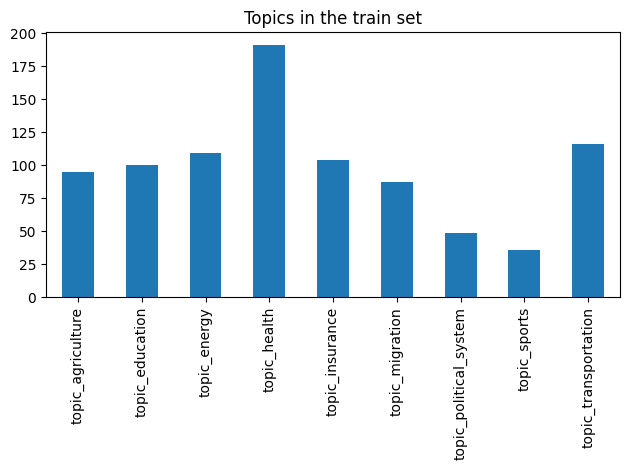

In [15]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "data/train_topic_counts.png",
    title="Topics in the train set",
)

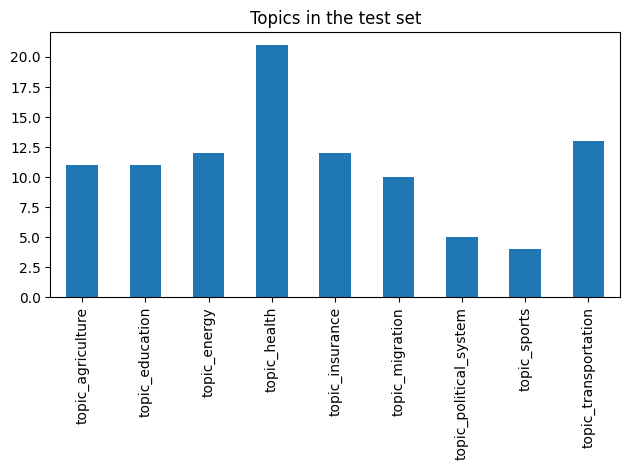

In [16]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "data/test_topic_counts.png",
    title="Topics in the test set",
)

# Classification

In [17]:
X_train, y_train = demokratis_ml.models.consultation_topics.model.create_matrices(df_input_train, topic_columns)
X_test, y_test = demokratis_ml.models.consultation_topics.model.create_matrices(df_input_test, topic_columns)

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (738, 9216) (738, 9)
Test (84, 9216) (84, 9)


## CV

In [18]:
classifier_cv = demokratis_ml.models.consultation_topics.model.create_classifier(RANDOM_STATE)
classifier_cv

,steps,"[('standardscaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,400
,copy,True
,whiten,False
,svd_solver,'auto'


In [19]:
cv = iterstrat.ml_stratifiers.MultilabelStratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None, column_name: str = "") -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    if (pca := demokratis_ml.models.consultation_topics.model.get_pca_step(pipeline)) is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        **{
            f"pca_explained_variance_{c}": functools.partial(explained_variance_scorer, column_name=c)
            for c in (
                "embedding_consultation_title",
                "embedding_consultation_description",
                "embedding_documents",
                "organisation_uuid",
                "embeddings",
            )
        },
    },
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no 

[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s


{'fit_time': array([2.1213479 , 1.97672391, 2.04748178, 2.12192011, 2.02568674]),
 'score_time': array([0.03527093, 0.04127097, 0.04032111, 0.03561497, 0.03639698]),
 'test_precision': array([0.87152778, 0.8630137 , 0.88333333, 0.89977477, 0.87777778]),
 'test_recall': array([0.84837963, 0.8196347 , 0.89111111, 0.87162162, 0.87666667]),
 'test_f1': array([0.85046296, 0.82968037, 0.87866667, 0.87815315, 0.86733333]),
 'test_pca_explained_variance_embedding_consultation_title': array([0.96882603, 0.96857309, 0.96958754, 0.96870678, 0.96926408]),
 'test_pca_explained_variance_embedding_consultation_description': array([0.96882603, 0.96857309, 0.96958754, 0.96870678, 0.96926408]),
 'test_pca_explained_variance_embedding_documents': array([0.96882603, 0.96857309, 0.96958754, 0.96870678, 0.96926408]),
 'test_pca_explained_variance_organisation_uuid': array([0.96882603, 0.96857309, 0.96958754, 0.96870678, 0.96926408]),
 'test_pca_explained_variance_embeddings': array([0.96882603, 0.96857309, 


cross_val_predict...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


In [20]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores.items() if k.startswith("test_")})

{'cv_f1': 0.8609,
 'cv_pca_explained_variance_embedding_consultation_description': 0.969,
 'cv_pca_explained_variance_embedding_consultation_title': 0.969,
 'cv_pca_explained_variance_embedding_documents': 0.969,
 'cv_pca_explained_variance_embeddings': 0.969,
 'cv_pca_explained_variance_organisation_uuid': 0.969,
 'cv_precision': 0.8791,
 'cv_recall': 0.8615}


cv_classification_report.txt

                  precision    recall  f1-score   support

     agriculture       0.88      0.88      0.88        95
       education       0.99      0.85      0.91       100
          energy       0.96      0.89      0.92       109
          health       0.89      0.81      0.85       191
       insurance       0.96      0.86      0.90       104
       migration       0.95      0.86      0.90        87
political_system       0.98      0.84      0.90        49
          sports       1.00      0.75      0.86        36
  transportation       0.97      0.84      0.90       116

       micro avg       0.94      0.85      0.89       887
       macro avg       0.95      0.84      0.89       887
    weighted avg       0.94      0.85      0.89       887
     samples avg       0.95      0.86      0.86       887



/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


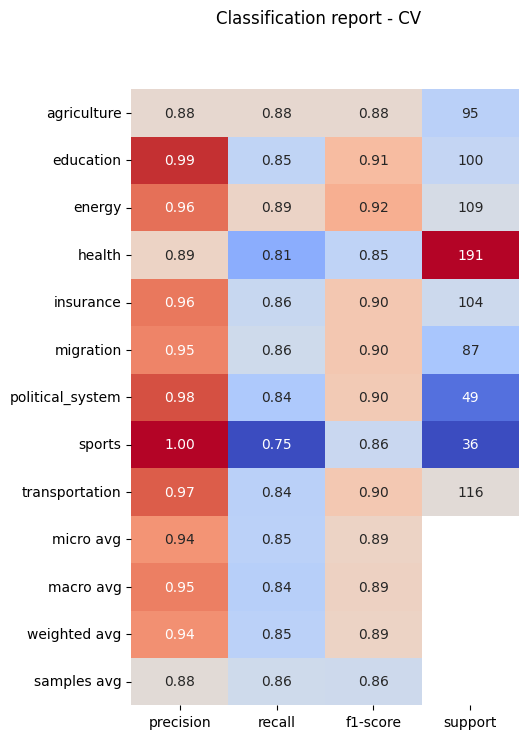

<Figure size 640x480 with 0 Axes>

In [21]:
utils.log_classification_report("cv", y_train, y_cv_predicted, target_names=SUPPORTED_TOPICS)
fig = plotting.plot_classification_report_heatmap(
    y_train.values,
    y_cv_predicted,
    target_names=SUPPORTED_TOPICS,
)
fig.suptitle("Classification report - CV")
plt.tight_layout()
mlflow.log_figure(fig, "cv_classification_report.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


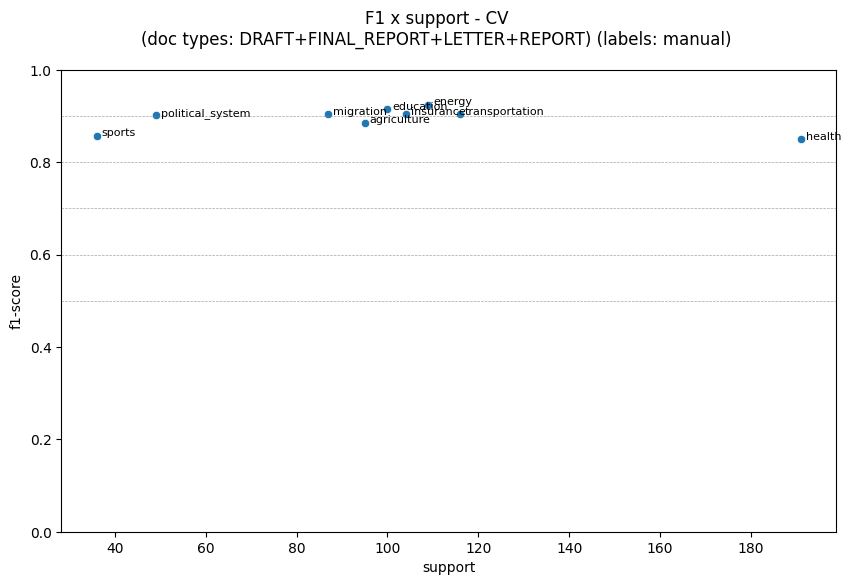

<Figure size 640x480 with 0 Axes>

In [22]:
fig = plotting.plot_score_against_support(
    y_train.values,
    y_cv_predicted,
    target_names=SUPPORTED_TOPICS,
)
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
# label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
label_sources = "+".join(sorted(TOPIC_LABEL_SOURCES))
fig.suptitle(
    "\n".join(
        [
            "F1 x support - CV",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
plt.tight_layout()
mlflow.log_figure(fig, "cv_score_against_support.png")
fig

In [28]:
report = pd.DataFrame(
    sklearn.metrics.classification_report(
        y_train.values,
        y_cv_predicted,
        target_names=SUPPORTED_TOPICS,
        output_dict=True,
        zero_division=np.nan,
    )
).transpose()["f1-score"]
# Print a dict of F1 scores for each topic that can be used for ignoring topics (in the Setup section)
{
    topic: round(f1, 3)
    for topic, f1 in report.items()
    if topic not in {"micro avg", "macro avg", "weighted avg", "samples avg"}
}

{'agriculture': 0.884,
 'education': 0.914,
 'energy': 0.924,
 'health': 0.849,
 'insurance': 0.904,
 'migration': 0.904,
 'political_system': 0.901,
 'sports': 0.857,
 'transportation': 0.903}

## Training

2025/07/31 13:52:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2025/07/31 13:52:57 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/31 13:52:57 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/31 13:52:57 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/31 13:53:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

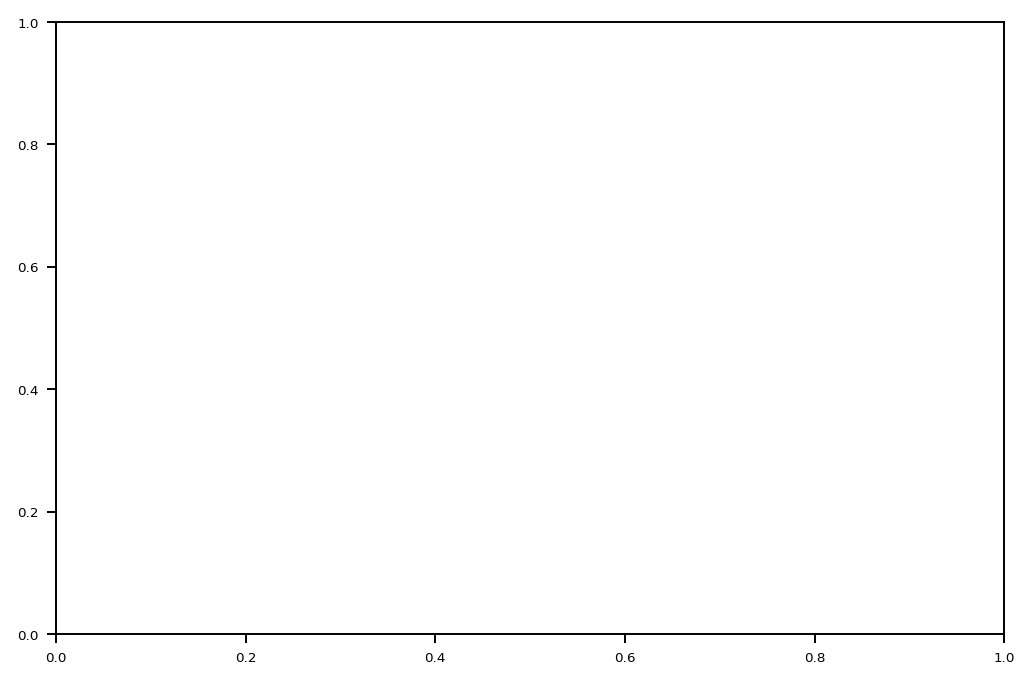

In [24]:
classifier_test = demokratis_ml.models.consultation_topics.model.create_classifier(RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [25]:
y_test_predicted = classifier_test.predict(X_test)

precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test,
    y_test_predicted,
    average="samples",
    zero_division=np.nan,
)
test_scores = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
utils.log_metrics(**test_scores)

{'test_f1': 0.8571, 'test_precision': 0.9423, 'test_recall': 0.8631}


test_classification_report.txt

                  precision    recall  f1-score   support

     agriculture       1.00      0.82      0.90        11
       education       1.00      0.91      0.95        11
          energy       1.00      0.92      0.96        12
          health       0.79      0.90      0.84        21
       insurance       0.83      0.83      0.83        12
       migration       1.00      0.70      0.82        10
political_system       1.00      0.60      0.75         5
          sports       1.00      1.00      1.00         4
  transportation       1.00      0.85      0.92        13

       micro avg       0.92      0.85      0.88        99
       macro avg       0.96      0.84      0.89        99
    weighted avg       0.94      0.85      0.88        99
     samples avg       0.94      0.86      0.86        99



/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


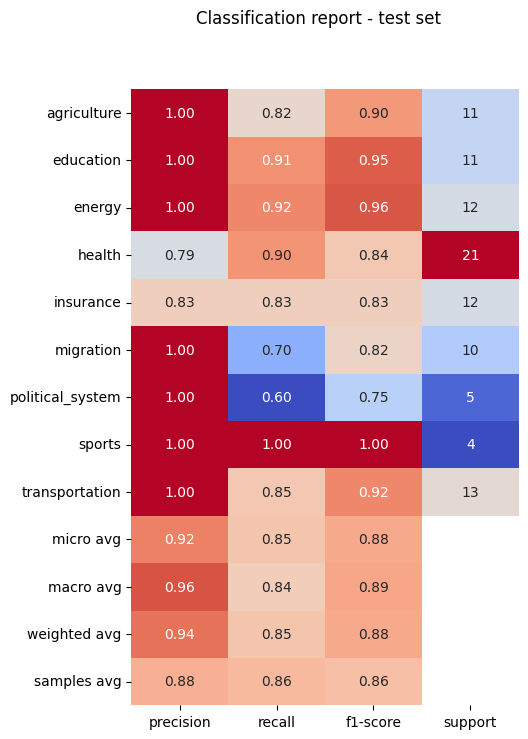

<Figure size 640x480 with 0 Axes>

In [26]:
utils.log_classification_report(
    "test",
    y_test,
    y_test_predicted,
    target_names=SUPPORTED_TOPICS,
)

fig = plotting.plot_classification_report_heatmap(
    y_test,
    y_test_predicted,
    target_names=SUPPORTED_TOPICS,
)
fig.suptitle("Classification report - test set")
mlflow.log_figure(fig, "test_classification_report.png")
plt.tight_layout()
display(fig)

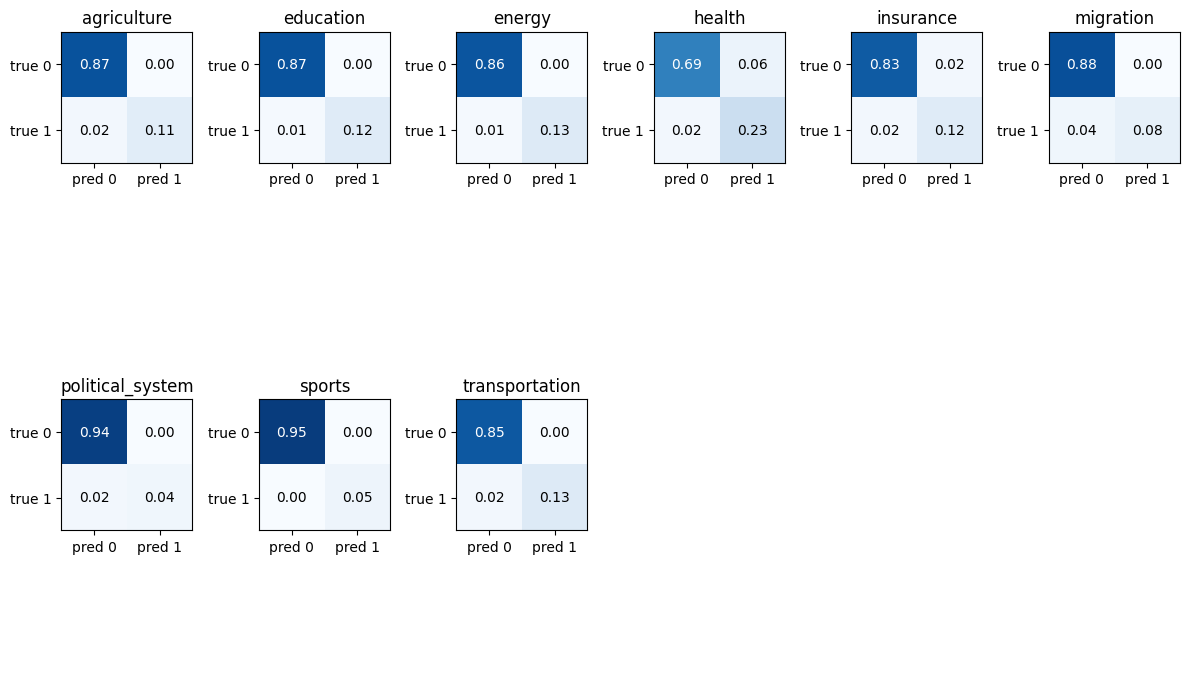

In [27]:
def plot_multilabel_confusion_matrices(Y_true: np.ndarray, Y_pred: np.ndarray, class_names: list[str]) -> None:
    """
    Plot confusion matrices (2x2) for each label as heatmaps.
    """
    cm_list = sklearn.metrics.multilabel_confusion_matrix(Y_true, Y_pred)
    n_classes = len(class_names)
    n_cols = 6
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, (cm, label) in enumerate(zip(cm_list, class_names, strict=True)):
        cm = cm / cm.sum()  # noqa: PLW2901
        # assert cm.sum() == 1.0

        ax = axes[i]
        ax.imshow(cm, interpolation="nearest", cmap="Blues", vmin=0, vmax=1)
        ax.set_title(label)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["pred 0", "pred 1"])
        ax.set_yticklabels(["true 0", "true 1"])

        # Annotate cells
        thresh = cm.max() / 2.0
        for j in range(2):
            for k in range(2):
                ax.text(
                    k,
                    j,
                    format(cm[j, k], ".2f"),
                    ha="center",
                    va="center",
                    color="white" if cm[j, k] > thresh else "black",
                )

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    plt.show()


plot_multilabel_confusion_matrices(y_test, y_test_predicted, class_names=SUPPORTED_TOPICS)

***

# End MLflow run

In [ ]:
# model_info = mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="consultation_topic_classifier",
#     metadata={"supported_topics": SUPPORTED_TOPICS},
# )
# model_info

2025/07/31 13:54:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/07/31 13:54:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'consultation_topic_classifier' already exists. Creating a new version of this model...
2025/07/31 13:54:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: consultation_topic_classifier, version 4
Created version '4' of model 'consultation_topic_classifier'.


In [30]:
mlflow.end_run()

🏃 View run adorable-sponge-142 at: https://mlflow.ml1.demokratis.ch/#/experiments/7/runs/0cc6323a0e4940f9b2b4b595170dd301
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/7


***

# Cleanlab

In [ ]:
RUN_CLEANLAB = False

In [ ]:
import cleanlab
import cleanlab.internal.multilabel_utils

from research.lib import cleanlab_analysis

if RUN_CLEANLAB:
    df_cleanlab = pd.concat([df_input_train, df_input_test], ignore_index=True)
    X_cleanlab, y_cleanlab = demokratis_ml.models.consultation_topics.model.create_matrices(df_cleanlab, topic_columns)
    print(X_cleanlab.shape)
    classifier_cleanlab = demokratis_ml.models.consultation_topics.model.create_classifier(RANDOM_STATE)
    pred_probs_list = sklearn.model_selection.cross_val_predict(
        estimator=classifier_cleanlab,
        X=X_cleanlab,
        y=y_cleanlab,
        cv=cv,
        method="predict_proba",
        n_jobs=-1,
        verbose=2,
    )
    pred_probs = demokratis_ml.models.consultation_topics.model.get_predicted_label_probabilities(pred_probs_list)
    print(pred_probs.shape)
    assert pred_probs.shape[0] == len(df_cleanlab)
    assert pred_probs.shape[1] == len(topic_columns)

In [ ]:
if RUN_CLEANLAB:
    labels = cleanlab.internal.multilabel_utils.onehot2int(y_cleanlab.values)
    lab = cleanlab.Datalab(
        data={
            "X": X_cleanlab,
            "labels": labels,
        },
        label_name="labels",
        task="multilabel",
    )
    lab.find_issues(pred_probs=pred_probs, features=X_cleanlab)
    lab.report()

In [ ]:
if RUN_CLEANLAB:
    df_output = df_cleanlab.copy()
    df_output = df_output[
        [
            "consultation_url",
            "consultation_title",
            "consultation_description",
            "organisation_name",
        ]
    ]
    true_labels = y_cleanlab.copy()
    true_labels.columns = [c.replace("topic_", "") for c in true_labels.columns]
    issue_dfs = cleanlab_analysis.cleanlab_issues_to_excel(
        lab,
        pred_probs=pred_probs,
        dataset=df_output,
        multilabel_true_labels=true_labels,
        output_path=f"cleanlab_issues_{DATA_VERSION}.xlsx",
        linkify_columns={
            "consultation_url",
        },
        issue_types=(
            "label",
            "near_duplicate",
            "outlier",
            # "underperforming_group",
            "non_iid",
        ),
    )